In [1]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
# Example chromatic_n = 4 cnf formula (SAT)
clauses = [ # Solution [1, 1, 0, 1, 0, 1, 1, 1, 0, 0]
    [1, 4], [1, 5], [1, 6],
    [2, 4], [2, 5], [2, 7],
    [3, 4], [3, 6], [3, 7],
    [-1, -2, 8],
    [-1, -3, 9],
    [-2, -3, 10],
    [-8, -9, -10, 11]
]

In [3]:
import random

# Regular walksat
def walkSAT(clauses, max_tries, max_flips, p):
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _ in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _ in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment  # Found a satisfying assignment
            
            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip

                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)

    return "FAIL"

# Parameters
max_tries = 100
max_flips = 1000
p = 0.5

# Running WalkSAT
result = walkSAT(clauses, max_tries, max_flips, p)
print("Satisfying assignment found:" if result != "FAIL" else "No satisfying assignment found within the given limits.", result)

Satisfying assignment found: {1: False, 2: False, 3: True, 4: True, 5: True, 6: True, 7: True, 8: True, 9: False, 10: True, 11: True}


In [4]:
def read_dimacs(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                _, _, variables, _ = line.split()
                num_vars = int(variables)
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                clauses.append(clause)
    return num_vars, clauses

num_vars, clauses = read_dimacs("/home/dae/SatExperiments/juniper/easiestcnf.cnf")

{6: 0, 7: 1, 8: 2, 10: 0, 1: 0, 2: 1, 3: 2, 4: 2, 5: 1, 9: 2, 11: 1, 12: 1}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


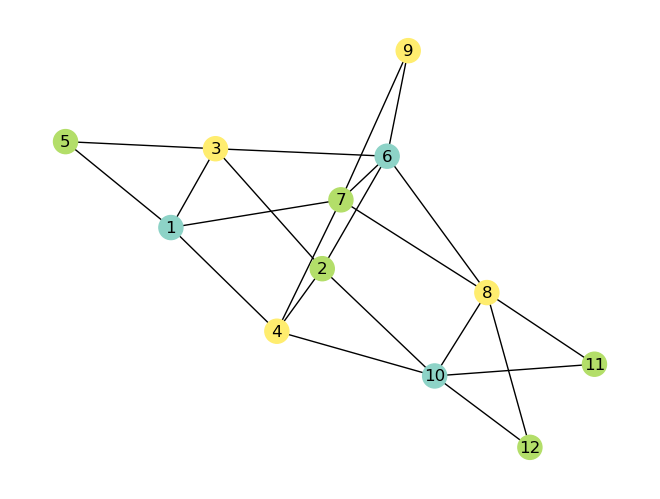

In [17]:
# The hidden culprit: this graph is not doing what you think it is ;)
num_vars, clauses = read_dimacs("/home/dae/SatExperiments/juniper/easiestcnf.cnf")
variables = set(abs(literal) for clause in clauses for literal in clause)
variables.remove(0)
# Variable adjacency graph
G = nx.Graph()
G.add_nodes_from(variables)

# Edges between variables that appear together in a clause
for clause in clauses:
    vars_in_clause = set(abs(literal) for literal in clause)
    vars_in_clause.remove(0)
    for var1, var2 in combinations(vars_in_clause, 2):
        G.add_edge(var1, var2)

# Greedy coloring , returns dictionary of unique colors (0 to n) for each node
colors = nx.coloring.greedy_color(G, strategy='largest_first')

print(colors)
print(variables)
color_values = [colors[node] for node in G.nodes()]

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=color_values, cmap=plt.cm.Set3)
plt.show()


In [6]:
import random

# Initial, correlated implementation
def ColorWalkSAT(clauses, colors, max_tries, max_loops, p):

    # Same as before
    def evaluate_clause(clause, assignment):
        return any(
            (var > 0 and assignment.get(abs(var), False)) or
            (var < 0 and not assignment.get(abs(var), False))
            for var in clause
        )

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]
    
    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)
    
    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]
    
    variables = list(get_variables(clauses))
    
    # Group variables by color
    color_vars = {}
    for var in variables:
        color = colors.get(var, None)
        if color is not None:
            color_vars.setdefault(color, []).append(var)
        else:
            # Handle variables without a color assignment
            color_vars.setdefault('no_color', []).append(var)

    for _ in range(max_tries):

        # We still start with a random phase
        assignment = {var: random.choice([True, False]) for var in variables}

        for _ in range(max_loops):
            
            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            
            if not unsatisfied:
                return assignment  # Found a satisfying assignment

            # Iterate over colors
            # This can be broken down into one per color, or in parallel instead of pipelined.

            for color in color_vars:
                vars_in_color = color_vars[color]
                # Find unsatisfied clauses involving variables of this color
                unsat_clauses_in_color = [
                    clause for clause in unsatisfied
                    if any(abs(var) in vars_in_color for var in clause)
                ]

                if not unsat_clauses_in_color:
                    continue  # No unsatisfied clauses involving this color

                # Randomly select one unsatisfied clause which has this color present (at least one literal has the color)
                clause = random.choice(unsat_clauses_in_color)

                if random.random() < p:
                    # Flip a random variable from the clause if and only if it also has the given color.
                    vars_in_clause_and_color = [
                        abs(var) for var in clause if abs(var) in vars_in_color
                    ]
                    var_to_flip = random.choice(vars_in_clause_and_color)
                else:
                    # Flip the variable that minimizes the number of unsatisfied clauses if flipped
                    # Has to be one of the ones from a given color
                    
                    break_counts = []
                    for var in clause:
                        var = abs(var)
                        if var in vars_in_color:
                            assignment[var] = not assignment[var]
                            num_unsat = len(get_unsatisfied_clauses(clauses, assignment))
                            break_counts.append((num_unsat, var))
                            assignment[var] = not assignment[var]  # Undo the flip
                    if not break_counts:
                        continue
                    min_break = min(break_counts, key=lambda x: x[0])
                    vars_with_min_break = [
                        var for count, var in break_counts if count == min_break[0]
                    ]
                    var_to_flip = random.choice(vars_with_min_break)

                flip_variable(assignment, var_to_flip)
    
    return "FAIL"


# Parameters
max_tries = 10
max_loops = 100
p = 0.5
colors = {1: 0, 2: 1, 3: 2, 8: 2, 9: 1, 10: 0, 4: 3, 11: 3, 5: 2, 6: 1, 7: 0}

# Running WalkSAT
result = ColorWalkSAT(clauses, colors, max_tries, max_loops, p)
if result != "FAIL":
    print("SAT:")
    for var in sorted(result):
        print(f"Variable {var} (Color {colors.get(var, 'N/A')}): {result[var]}")
else:
    print("No satisfying assignment found within the given limits.")

No satisfying assignment found within the given limits.


In [7]:
def read_dimacs(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                _, _, variables, _ = line.split()
                num_vars = int(variables)
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                clauses.append(clause)
    return num_vars, clauses

In [8]:
num_vars, clauses = read_dimacs("/home/dae/SatExperiments/uf50suiteSATLIB/uf5001.cnf")
variables = set(abs(literal) for clause in clauses for literal in clause)

# Variable adjacency graph
G = nx.Graph()
G.add_nodes_from(variables)

# Edges between variables that appear together in a clause
for clause in clauses:
    vars_in_clause = set(abs(literal) for literal in clause)
    for var1, var2 in combinations(vars_in_clause, 2):
        G.add_edge(var1, var2)

# Greedy coloring , returns dictionary of unique colors (0 to n) for each node
colors = nx.coloring.greedy_color(G, strategy='largest_first')


In [9]:
def task(color, assignment, color_vars):
        def evaluate_clause(clause, assignment):
            return any(
                (var > 0 and assignment.get(abs(var), False)) or
                (var < 0 and not assignment.get(abs(var), False))
                for var in clause
            )


        def get_unsatisfied_clauses(clauses, assignment):
             return [clause for clause in clauses if not evaluate_clause(clause, assignment)]
        
        def flip_variable(assignment, var):
             assignment[var] = not assignment[var]
        
        unsatisfied = get_unsatisfied_clauses(clauses, assignment)
        
        if not unsatisfied:
            return assignment  # Found a satisfying assignment

        vars_in_color = color_vars[color]
        # Find unsatisfied clauses involving variables of this color
        unsat_clauses_in_color = [
            clause for clause in unsatisfied
            if any(abs(var) in vars_in_color for var in clause)
        ]

        if not unsat_clauses_in_color:
            return  # No unsatisfied clauses involving this color

        # Randomly select one unsatisfied clause which has this color present (at least one literal has the color)
        clause = random.choice(unsat_clauses_in_color)

        if random.random() < p:
            # Flip a random variable from the clause if and only if it also has the given color.
            vars_in_clause_and_color = [
                abs(var) for var in clause if abs(var) in vars_in_color
            ]
            var_to_flip = random.choice(vars_in_clause_and_color)
        else:
            # Flip the variable that minimizes the number of unsatisfied clauses if flipped
            # Has to be one of the ones from a given color
            # Changing so it does not matter what color you are
            
            break_counts = []
            for var in clause:
                var = abs(var)
                if var in vars_in_color: # comment this to make only the random flip prioritize color half/half algorithm
                    assignment[var] = not assignment[var]
                    num_unsat = len(get_unsatisfied_clauses(clauses, assignment))
                    break_counts.append((num_unsat, var))
                    assignment[var] = not assignment[var]  # Undo the flip
            if not break_counts:
                return
            min_break = min(break_counts, key=lambda x: x[0])
            vars_with_min_break = [
                var for count, var in break_counts if count == min_break[0]
            ]
            var_to_flip = random.choice(vars_with_min_break)

        flip_variable(assignment, var_to_flip)


In [10]:
import random
import subprocess
import multiprocessing


# Now, making the inside of the for loop atomic then multiprocessing the atoms
"""

process = multiprocessing.Process(target=task)

def ColorWalkSAT(clauses, colors, max_tries, max_loops, p):

    # Same as before
    def evaluate_clause(clause, assignment):
        return any(
            (var > 0 and assignment.get(abs(var), False)) or
            (var < 0 and not assignment.get(abs(var), False))
            for var in clause
        )

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]
    
    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)
    
    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]
    
    variables = list(get_variables(clauses))
    
    # Group variables by color
    color_vars = {}
    for var in variables:
        color = colors.get(var, None)
        if color is not None:
            color_vars.setdefault(color, []).append(var)
        else:
            # Handle variables without a color assignment
            color_vars.setdefault('no_color', []).append(var)

    for _ in range(max_tries):

        # We still start with a random phase
        assignment = {var: random.choice([True, False]) for var in variables}

        for _ in range(max_loops):
            process = multiprocessing.Process(target=task, args=(color, assignment, color_vars))
            process.start()
            
    return "FAIL"


# Parameters
max_tries = 100
max_loops = 100000
p = 0.5


# Running WalkSAT
result = ColorWalkSAT(clauses, colors, max_tries, max_loops, p)

# Half and half is way faster but less parallel maybe? I need to run each instance
# of the for loop as an independent process !!!!!
# Yes each color becomes its own process "colorX" and it communicates pipelining to a parent
# A parent node that does the outer loop

if result != "FAIL":
    print("SAT:")
    for var in sorted(result):
        print(f"Variable {var} (Color {colors.get(var, 'N/A')}): {result[var]}")
else:
    print("No satisfying assignment found within the given limits.")
    """

'\n\nprocess = multiprocessing.Process(target=task)\n\ndef ColorWalkSAT(clauses, colors, max_tries, max_loops, p):\n\n    # Same as before\n    def evaluate_clause(clause, assignment):\n        return any(\n            (var > 0 and assignment.get(abs(var), False)) or\n            (var < 0 and not assignment.get(abs(var), False))\n            for var in clause\n        )\n\n    def get_unsatisfied_clauses(clauses, assignment):\n        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]\n    \n    def get_variables(clauses):\n        return set(abs(var) for clause in clauses for var in clause)\n    \n    def flip_variable(assignment, var):\n        assignment[var] = not assignment[var]\n    \n    variables = list(get_variables(clauses))\n    \n    # Group variables by color\n    color_vars = {}\n    for var in variables:\n        color = colors.get(var, None)\n        if color is not None:\n            color_vars.setdefault(color, []).append(var)\n        el